In [1]:
from sklearn.metrics import f1_score, accuracy_score
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import mobilenet_v2
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn import Dropout
from torch.nn import Conv1d
from torch.nn import BatchNorm1d
from torch.nn import BatchNorm2d
import torch.nn as nn
import torch
import torchvision
import os, shutil, glob
from shutil import copyfile
import pandas as pd
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [2]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [3]:
def save_encoder(file_name, encoder):
    with open(file_name, 'wb') as le_dump_file:
        pickle.dump(encoder, le_dump_file)
    return


class BaseDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder_file='label_encoder.pkl'):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            save_encoder(encoder_file, self.label_encoder)
    
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(file)
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x , dtype='float32') / 255.
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        w,h = image.size
        img0 = image
        if (w > h):
            img0 = transforms.Pad((0,(w-h)//2,0,w-h-((w-h)//2)))(image)
        elif (w < h):
            img0 = transforms.Pad(((h-w)//2,0,h-w-((h-w)//2), 0))(image)
        w,h = img0.size
        if(w == RESCALE_SIZE and h == RESCALE_SIZE):
            return img0
        return transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(img0)

In [4]:
class TransformedDataset(BaseDataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и делает рандом кроп с аугментацией
    """
    def __init__(self, files, mode, encoder_file='label_encoder.pkl'):
        super().__init__(files, mode, encoder_file)
        return


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        image = Image.open(file)
        #image.load()
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        hh = max(0, int(np.random.randn()*22.))
        hh = hh if(hh*10 < RESCALE_SIZE) else 22
        if(hh > 0):
            x = transforms.RandomCrop((RESCALE_SIZE-hh,RESCALE_SIZE-hh))(x)
            x = transforms.RandomApply((transforms.RandomHorizontalFlip(), 
                                        transforms.RandomAffine(degrees=75, scale=(0.7, 1.1), shear=0.2)), p=0.8)(x)
            x = transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(x)
        x = np.array(x, dtype='float32')/ 255.0
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        


In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
from torch.optim import SGD
from torchvision.models import mobilenet_v2
matplotlib.style.use('ggplot')
# создаем класс TrainClassifier для тренировки моделей на pytorch


def __get_device__(): # получаем устройство
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def default_lr_schedule():
    """функция возвращает итератор с 320 значениями learning rate"""
    lrs = [0.002/(1.+0.9*n) for n in np.arange(20)] # range(100)
    lrs.extend([0.0002 - (0.0000005*k) for k in np.arange(300)])
    return lrs.__iter__()

    
def mobilenetv2(n_outputs = 2):
    simple_cnn = mobilenet_v2(pretrained=False)
    simple_cnn.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.BatchNorm1d(1280),
        nn.Linear(1280, n_outputs, bias=True))
    return simple_cnn


def original_mobilenetv2(n_outputs = 12):
    simple_cnn = mobilenet_v2(pretrained=True)
    simple_cnn.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, n_outputs, bias=True))
    return simple_cnn


class TrainClassifier:
    
    def __init__(self, n_outputs, model:nn.Module = None, criterion = None, batch_size = 64):
        self.device = __get_device__()
        self.neuralnet = mobilenetv2(n_outputs).to(self.device) if model is None else model.to(self.device)
        self.criterion = nn.CrossEntropyLoss() if criterion is None else criterion
        self.optimizer = torch.optim.Adam(self.neuralnet.parameters())
        self.optimizer_generator = None
        self.batch_size = batch_size
        self.epochs = 100
        self.finalizer = None
        self.total_epochs = 0
        self.history = []
        return


    def __optimizer_gen__(self, optimizer_type, lr_schedule):
        self.lr = lr_schedule.__next__()
        while self.lr is not None:
            print('LR = ', self.lr)
            yield torch.optim.Adam(self.neuralnet.parameters(), lr = self.lr) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters(), lr = lr)
            self.lr = lr_schedule.__next__()
        return


    def __fit_once__(self, train_loader):
        self.neuralnet.train()
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
        if (self.optimizer_generator is not None):
            self.optimizer = self.optimizer_generator.__next__()
        k = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.neuralnet(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
            k += 1
            if (k%500 == 0):
                print(k)
        loss = running_loss / processed_data
        acc = running_corrects.cpu().numpy() / processed_data
        self.total_epochs += 1
        return loss, acc


    def __eval_once__(self, val_loader):
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.neuralnet.eval()
            with torch.set_grad_enabled(False):
                outputs = self.neuralnet(inputs)
                loss = self.criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
        loss = running_loss / processed_size
        acc = running_corrects.double() / processed_size
        return loss, acc.item()


    def with_epochs(self, epochs, finalizer=None):
        self.epochs = epochs
        return self


    def with_lr(self, lr, optimizer_type = 'adam'):
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.neuralnet.parameters(), lr=lr) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters(), lr=lr)
        return self


    def with_optimizer(self, optimizer_type, lr_schedule = None):
        if(lr_schedule is None):
            self.optimizer = torch.optim.Adam(self.neuralnet.parameters()) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters())
        else:
            self.lr_schedule = lr_schedule
            self.optimizer_generator = self.__optimizer_gen__(optimizer_type, lr_schedule)
        return self


    def with_metrics(self, metric = 'acc'):
        self.metric = 'acc'
        return self


    #supports only mathplotlib.pyplot
    def with_graph(self, graph_type = 'loss_results'):
        def draw_func(history):
            if (len(history) == 0):
                return
            loss, res, val_loss, val_res = zip(*history)
            plt.figure(figsize=(9, 7))
            if (graph_type == 'results'):
                plt.plot(res, label="train_acc")
                plt.plot(val_res, label="val_acc")
                plt.ylabel("acc")
            elif (graph_type == 'loss' or graph_type == 'loss_results'):
                plt.plot(loss, label="train_loss")
                plt.plot(val_loss, label="val_loss")
                plt.ylabel("loss")
                if (graph_type == 'loss_results'):
                    plt.legend(loc='best')
                    plt.xlabel("epochs")
                    plt.show()
                    plt.figure(figsize=(9, 7))
                    plt.plot(res, label="train_acc")
                    plt.plot(val_res, label="val_acc")
                    plt.ylabel("acc")
            else:
                return
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.show()
            return

        self.draw_fn = draw_func
        return self


    #terminal operation
    def fit(self, train_dataset, val_dataset, enable_tqdm=False):
        end_results = []
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader =    DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        log_template = "\nEpoch {ep:03d} train loss: {t_loss:0.4f} valid loss {v_loss:0.4f} train acc {t_acc:0.4f} valid acc {v_acc:0.4f}"
        def display_results(train_loss, train_acc, val_loss, val_acc, epoch, pbar, log_template):
            if (enable_tqdm):
                pbar.update(1)
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            else:
                print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        
        
        def cycle(pbar):
            for epoch in range(self.epochs):
                train_loss, train_acc = self.__fit_once__(train_loader)
                val_loss, val_acc = self.__eval_once__(val_loader)
                end_results.append((train_loss, train_acc, val_loss, val_acc))
                display_results(train_loss, train_acc, val_loss, val_acc, epoch, pbar, log_template)
        

        if (enable_tqdm):
            with tqdm(desc="epoch", total=self.epochs) as pbar:
                cycle(pbar)
        else:
            cycle(None)
        self.history.extend(end_results)
        return end_results


    def evaluate(self, val_dataset):    #terminal operation
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return self.__eval_once__(val_loader)


    def do_fit(self, train_dataset, val_dataset, enable_tqdm=False):
        hist = self.fit(train_dataset, val_dataset, enable_tqdm)
        return self


    def do_evaluate(self, val_dataset):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        loss, acc = self.__eval_once__(val_loader)
        print("evaluation loss/acc: ", loss, acc)
        return self


    def display_history(self):    #terminal operation
        if(self.draw_fn is not None):
            self.draw_fn(self.history)
        return
    

    def display_model(self):    #terminal operation
        print(self.neuralnet)


    def display_all(self, print_model = False):    #terminal operation
        self.display_history()
        if (print_model):
            self.display_model()
        return


    def save_dict(self, name):
        torch.save(self.neuralnet.state_dict(), name + '.dict')



In [9]:
from sklearn.model_selection import train_test_split
# Инициализируем датасеты 
# далее тренируем сеть на основе MobileNet v2
# в течении 80 эпох постепенно уменьшая LR
torch.manual_seed(17)
np.random.seed(17)

# скопировал картинки после работы preprocess_img.ipynb в каталог train
# из всех картинок перенес с удалением в источнике по 30 картинок из каталогов 0 и 1 в testset
TRAIN_DIR = Path('./train')
# каталог для test set
TEST_DIR = Path('./testset')

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_dataset = BaseDataset(test_files, mode="val")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
labels = [path.parent.name for path in train_val_files]

#dataset
train_files, val_files = train_test_split(train_val_files, test_size=0.15, stratify=labels)
train_dataset = TransformedDataset(train_files, mode='train')
val_dataset = BaseDataset(val_files, mode='val')
val_dataset_a = TransformedDataset(val_files, mode='val')


epoch:   0%|          | 0/80 [00:00<?, ?it/s]

LR =  0.002


epoch:   1%|▏         | 1/80 [00:41<54:57, 41.74s/it]


Epoch 001 train loss: 0.4020 valid loss 0.7146 train acc 0.8392 valid acc 0.4900
LR =  0.0010526315789473684


epoch:   2%|▎         | 2/80 [01:21<53:22, 41.06s/it]


Epoch 002 train loss: 0.1923 valid loss 0.1050 train acc 0.9278 valid acc 0.9672
LR =  0.0007142857142857144


epoch:   4%|▍         | 3/80 [02:00<52:04, 40.58s/it]


Epoch 003 train loss: 0.1166 valid loss 0.0934 train acc 0.9581 valid acc 0.9696
LR =  0.0005405405405405405


epoch:   5%|▌         | 4/80 [02:40<50:55, 40.21s/it]


Epoch 004 train loss: 0.0894 valid loss 0.1046 train acc 0.9663 valid acc 0.9576
LR =  0.0004347826086956522


epoch:   6%|▋         | 5/80 [03:19<49:58, 39.98s/it]


Epoch 005 train loss: 0.0862 valid loss 0.0623 train acc 0.9687 valid acc 0.9840
LR =  0.00036363636363636367


epoch:   8%|▊         | 6/80 [03:59<49:23, 40.04s/it]


Epoch 006 train loss: 0.0629 valid loss 0.0455 train acc 0.9801 valid acc 0.9872
LR =  0.0003125


epoch:   9%|▉         | 7/80 [04:39<48:37, 39.96s/it]


Epoch 007 train loss: 0.0598 valid loss 0.0414 train acc 0.9810 valid acc 0.9920
LR =  0.00027397260273972606


epoch:  10%|█         | 8/80 [05:19<47:54, 39.92s/it]


Epoch 008 train loss: 0.0495 valid loss 0.0417 train acc 0.9846 valid acc 0.9880
LR =  0.00024390243902439027


epoch:  11%|█▏        | 9/80 [05:59<47:18, 39.98s/it]


Epoch 009 train loss: 0.0465 valid loss 0.0385 train acc 0.9842 valid acc 0.9912
LR =  0.00021978021978021978


epoch:  12%|█▎        | 10/80 [06:38<46:22, 39.75s/it]


Epoch 010 train loss: 0.0429 valid loss 0.0342 train acc 0.9859 valid acc 0.9920
LR =  0.0002


epoch:  14%|█▍        | 11/80 [07:17<45:34, 39.63s/it]


Epoch 011 train loss: 0.0434 valid loss 0.0265 train acc 0.9873 valid acc 0.9952
LR =  0.0001834862385321101


epoch:  15%|█▌        | 12/80 [07:57<44:52, 39.59s/it]


Epoch 012 train loss: 0.0362 valid loss 0.0300 train acc 0.9880 valid acc 0.9936
LR =  0.0001694915254237288


epoch:  16%|█▋        | 13/80 [08:37<44:16, 39.64s/it]


Epoch 013 train loss: 0.0379 valid loss 0.0281 train acc 0.9867 valid acc 0.9944
LR =  0.00015748031496062991


epoch:  18%|█▊        | 14/80 [09:16<43:33, 39.59s/it]


Epoch 014 train loss: 0.0349 valid loss 0.0248 train acc 0.9870 valid acc 0.9928
LR =  0.00014705882352941178


epoch:  19%|█▉        | 15/80 [09:56<42:55, 39.63s/it]


Epoch 015 train loss: 0.0246 valid loss 0.0274 train acc 0.9908 valid acc 0.9936
LR =  0.00013793103448275863


epoch:  20%|██        | 16/80 [10:35<42:13, 39.59s/it]


Epoch 016 train loss: 0.0329 valid loss 0.0244 train acc 0.9894 valid acc 0.9928
LR =  0.00012987012987012987


epoch:  21%|██▏       | 17/80 [11:15<41:32, 39.57s/it]


Epoch 017 train loss: 0.0250 valid loss 0.0233 train acc 0.9913 valid acc 0.9936
LR =  0.0001226993865030675


epoch:  22%|██▎       | 18/80 [11:54<40:49, 39.51s/it]


Epoch 018 train loss: 0.0232 valid loss 0.0607 train acc 0.9928 valid acc 0.9840
LR =  0.00011627906976744187


epoch:  24%|██▍       | 19/80 [12:34<40:12, 39.54s/it]


Epoch 019 train loss: 0.0261 valid loss 0.0205 train acc 0.9904 valid acc 0.9960
LR =  0.00011049723756906077


epoch:  25%|██▌       | 20/80 [13:14<39:35, 39.60s/it]


Epoch 020 train loss: 0.0224 valid loss 0.0376 train acc 0.9938 valid acc 0.9904
LR =  0.0002


epoch:  26%|██▋       | 21/80 [13:53<38:58, 39.64s/it]


Epoch 021 train loss: 0.0312 valid loss 0.0262 train acc 0.9896 valid acc 0.9952
LR =  0.0001995


epoch:  28%|██▊       | 22/80 [14:33<38:15, 39.58s/it]


Epoch 022 train loss: 0.0309 valid loss 0.0230 train acc 0.9914 valid acc 0.9944
LR =  0.000199


epoch:  29%|██▉       | 23/80 [15:12<37:34, 39.55s/it]


Epoch 023 train loss: 0.0223 valid loss 0.0314 train acc 0.9932 valid acc 0.9936
LR =  0.0001985


epoch:  30%|███       | 24/80 [15:52<36:53, 39.53s/it]


Epoch 024 train loss: 0.0279 valid loss 0.0385 train acc 0.9914 valid acc 0.9944
LR =  0.00019800000000000002


epoch:  31%|███▏      | 25/80 [16:31<36:14, 39.54s/it]


Epoch 025 train loss: 0.0239 valid loss 0.0192 train acc 0.9922 valid acc 0.9960
LR =  0.0001975


epoch:  32%|███▎      | 26/80 [17:11<35:39, 39.61s/it]


Epoch 026 train loss: 0.0259 valid loss 0.0278 train acc 0.9920 valid acc 0.9952
LR =  0.00019700000000000002


epoch:  34%|███▍      | 27/80 [17:51<34:56, 39.56s/it]


Epoch 027 train loss: 0.0192 valid loss 0.0211 train acc 0.9924 valid acc 0.9952
LR =  0.0001965


epoch:  35%|███▌      | 28/80 [18:30<34:15, 39.53s/it]


Epoch 028 train loss: 0.0234 valid loss 0.0263 train acc 0.9928 valid acc 0.9952
LR =  0.00019600000000000002


epoch:  36%|███▋      | 29/80 [19:10<33:36, 39.53s/it]


Epoch 029 train loss: 0.0258 valid loss 0.0209 train acc 0.9917 valid acc 0.9952
LR =  0.0001955


epoch:  38%|███▊      | 30/80 [19:49<32:57, 39.55s/it]


Epoch 030 train loss: 0.0206 valid loss 0.0287 train acc 0.9929 valid acc 0.9944
LR =  0.00019500000000000002


epoch:  39%|███▉      | 31/80 [20:29<32:17, 39.55s/it]


Epoch 031 train loss: 0.0176 valid loss 0.0274 train acc 0.9929 valid acc 0.9936
LR =  0.0001945


epoch:  40%|████      | 32/80 [21:08<31:38, 39.56s/it]


Epoch 032 train loss: 0.0225 valid loss 0.0216 train acc 0.9927 valid acc 0.9912
LR =  0.000194


epoch:  41%|████▏     | 33/80 [21:48<31:00, 39.59s/it]


Epoch 033 train loss: 0.0249 valid loss 0.0398 train acc 0.9918 valid acc 0.9928
LR =  0.00019350000000000001


epoch:  42%|████▎     | 34/80 [22:28<30:21, 39.59s/it]


Epoch 034 train loss: 0.0168 valid loss 0.0499 train acc 0.9952 valid acc 0.9928
LR =  0.000193


epoch:  44%|████▍     | 35/80 [23:07<29:40, 39.56s/it]


Epoch 035 train loss: 0.0178 valid loss 0.0237 train acc 0.9938 valid acc 0.9952
LR =  0.00019250000000000002


epoch:  45%|████▌     | 36/80 [23:46<28:59, 39.52s/it]


Epoch 036 train loss: 0.0218 valid loss 0.0195 train acc 0.9928 valid acc 0.9944
LR =  0.000192


epoch:  46%|████▋     | 37/80 [24:26<28:21, 39.57s/it]


Epoch 037 train loss: 0.0180 valid loss 0.0148 train acc 0.9942 valid acc 0.9952
LR =  0.00019150000000000002


epoch:  48%|████▊     | 38/80 [25:06<27:44, 39.63s/it]


Epoch 038 train loss: 0.0162 valid loss 0.0274 train acc 0.9959 valid acc 0.9960
LR =  0.000191


epoch:  49%|████▉     | 39/80 [25:46<27:06, 39.68s/it]


Epoch 039 train loss: 0.0167 valid loss 0.0100 train acc 0.9945 valid acc 0.9944
LR =  0.00019050000000000002


epoch:  50%|█████     | 40/80 [26:26<26:37, 39.93s/it]


Epoch 040 train loss: 0.0200 valid loss 0.0090 train acc 0.9939 valid acc 0.9976
LR =  0.00019


epoch:  51%|█████▏    | 41/80 [27:06<25:58, 39.97s/it]


Epoch 041 train loss: 0.0112 valid loss 0.0356 train acc 0.9958 valid acc 0.9960
LR =  0.0001895


epoch:  52%|█████▎    | 42/80 [27:46<25:18, 39.95s/it]


Epoch 042 train loss: 0.0172 valid loss 0.0096 train acc 0.9948 valid acc 0.9960
LR =  0.000189


epoch:  54%|█████▍    | 43/80 [28:26<24:37, 39.93s/it]


Epoch 043 train loss: 0.0134 valid loss 0.0169 train acc 0.9949 valid acc 0.9944
LR =  0.0001885


epoch:  55%|█████▌    | 44/80 [29:06<23:52, 39.79s/it]


Epoch 044 train loss: 0.0148 valid loss 0.0168 train acc 0.9948 valid acc 0.9936
LR =  0.00018800000000000002


epoch:  56%|█████▋    | 45/80 [29:45<23:07, 39.66s/it]


Epoch 045 train loss: 0.0190 valid loss 0.0104 train acc 0.9935 valid acc 0.9976
LR =  0.0001875


epoch:  57%|█████▊    | 46/80 [30:25<22:28, 39.67s/it]


Epoch 046 train loss: 0.0133 valid loss 0.0104 train acc 0.9949 valid acc 0.9968
LR =  0.00018700000000000002


epoch:  59%|█████▉    | 47/80 [31:04<21:47, 39.62s/it]


Epoch 047 train loss: 0.0111 valid loss 0.0614 train acc 0.9959 valid acc 0.9824
LR =  0.0001865


epoch:  60%|██████    | 48/80 [31:44<21:07, 39.62s/it]


Epoch 048 train loss: 0.0129 valid loss 0.0232 train acc 0.9948 valid acc 0.9960
LR =  0.00018600000000000002


epoch:  61%|██████▏   | 49/80 [32:24<20:30, 39.68s/it]


Epoch 049 train loss: 0.0169 valid loss 0.0217 train acc 0.9946 valid acc 0.9960
LR =  0.0001855


epoch:  62%|██████▎   | 50/80 [33:03<19:50, 39.67s/it]


Epoch 050 train loss: 0.0134 valid loss 0.0321 train acc 0.9955 valid acc 0.9968
LR =  0.000185


epoch:  64%|██████▍   | 51/80 [33:43<19:10, 39.67s/it]


Epoch 051 train loss: 0.0141 valid loss 0.0168 train acc 0.9948 valid acc 0.9944
LR =  0.0001845


epoch:  65%|██████▌   | 52/80 [34:22<18:29, 39.63s/it]


Epoch 052 train loss: 0.0156 valid loss 0.0068 train acc 0.9944 valid acc 0.9976
LR =  0.000184


epoch:  66%|██████▋   | 53/80 [35:02<17:50, 39.64s/it]


Epoch 053 train loss: 0.0122 valid loss 0.0244 train acc 0.9963 valid acc 0.9936
LR =  0.00018350000000000002


epoch:  68%|██████▊   | 54/80 [35:42<17:09, 39.61s/it]


Epoch 054 train loss: 0.0130 valid loss 0.0098 train acc 0.9965 valid acc 0.9960
LR =  0.000183


epoch:  69%|██████▉   | 55/80 [36:22<16:33, 39.74s/it]


Epoch 055 train loss: 0.0114 valid loss 0.0157 train acc 0.9969 valid acc 0.9952
LR =  0.00018250000000000002


epoch:  70%|███████   | 56/80 [37:01<15:51, 39.66s/it]


Epoch 056 train loss: 0.0141 valid loss 0.0161 train acc 0.9951 valid acc 0.9944
LR =  0.000182


epoch:  71%|███████▏  | 57/80 [37:41<15:11, 39.63s/it]


Epoch 057 train loss: 0.0111 valid loss 0.0350 train acc 0.9965 valid acc 0.9880
LR =  0.00018150000000000002


epoch:  72%|███████▎  | 58/80 [38:21<14:33, 39.69s/it]


Epoch 058 train loss: 0.0092 valid loss 0.0050 train acc 0.9976 valid acc 0.9984
LR =  0.000181


epoch:  74%|███████▍  | 59/80 [39:00<13:53, 39.67s/it]


Epoch 059 train loss: 0.0113 valid loss 0.0144 train acc 0.9972 valid acc 0.9952
LR =  0.0001805


epoch:  75%|███████▌  | 60/80 [39:40<13:14, 39.74s/it]


Epoch 060 train loss: 0.0103 valid loss 0.0084 train acc 0.9973 valid acc 0.9952
LR =  0.00018


epoch:  76%|███████▋  | 61/80 [40:20<12:33, 39.67s/it]


Epoch 061 train loss: 0.0064 valid loss 0.0011 train acc 0.9977 valid acc 1.0000
LR =  0.0001795


epoch:  78%|███████▊  | 62/80 [40:59<11:54, 39.68s/it]


Epoch 062 train loss: 0.0122 valid loss 0.0117 train acc 0.9959 valid acc 0.9952
LR =  0.00017900000000000001


epoch:  79%|███████▉  | 63/80 [41:39<11:15, 39.72s/it]


Epoch 063 train loss: 0.0118 valid loss 0.0045 train acc 0.9962 valid acc 0.9984
LR =  0.0001785


epoch:  80%|████████  | 64/80 [42:19<10:35, 39.69s/it]


Epoch 064 train loss: 0.0136 valid loss 0.0269 train acc 0.9948 valid acc 0.9960
LR =  0.00017800000000000002


epoch:  81%|████████▏ | 65/80 [42:58<09:54, 39.65s/it]


Epoch 065 train loss: 0.0134 valid loss 0.0162 train acc 0.9955 valid acc 0.9944
LR =  0.0001775


epoch:  82%|████████▎ | 66/80 [43:38<09:15, 39.66s/it]


Epoch 066 train loss: 0.0075 valid loss 0.0055 train acc 0.9966 valid acc 0.9984
LR =  0.00017700000000000002


epoch:  84%|████████▍ | 67/80 [44:17<08:34, 39.61s/it]


Epoch 067 train loss: 0.0078 valid loss 0.0132 train acc 0.9972 valid acc 0.9976
LR =  0.0001765


epoch:  85%|████████▌ | 68/80 [44:57<07:55, 39.59s/it]


Epoch 068 train loss: 0.0083 valid loss 0.0084 train acc 0.9973 valid acc 0.9960
LR =  0.000176


epoch:  86%|████████▋ | 69/80 [45:36<07:15, 39.58s/it]


Epoch 069 train loss: 0.0083 valid loss 0.0086 train acc 0.9975 valid acc 0.9984
LR =  0.0001755


epoch:  88%|████████▊ | 70/80 [46:16<06:35, 39.51s/it]


Epoch 070 train loss: 0.0159 valid loss 0.0089 train acc 0.9946 valid acc 0.9968
LR =  0.00017500000000000003


epoch:  89%|████████▉ | 71/80 [46:56<05:56, 39.56s/it]


Epoch 071 train loss: 0.0126 valid loss 0.0016 train acc 0.9961 valid acc 1.0000
LR =  0.0001745


epoch:  90%|█████████ | 72/80 [47:35<05:15, 39.50s/it]


Epoch 072 train loss: 0.0106 valid loss 0.0043 train acc 0.9968 valid acc 0.9984
LR =  0.000174


epoch:  91%|█████████▏| 73/80 [48:14<04:36, 39.50s/it]


Epoch 073 train loss: 0.0086 valid loss 0.0029 train acc 0.9973 valid acc 1.0000
LR =  0.00017350000000000002


epoch:  92%|█████████▎| 74/80 [48:54<03:56, 39.49s/it]


Epoch 074 train loss: 0.0096 valid loss 0.0055 train acc 0.9972 valid acc 0.9992
LR =  0.000173


epoch:  94%|█████████▍| 75/80 [49:33<03:17, 39.47s/it]


Epoch 075 train loss: 0.0105 valid loss 0.0096 train acc 0.9962 valid acc 0.9976
LR =  0.00017250000000000002


epoch:  95%|█████████▌| 76/80 [50:13<02:37, 39.44s/it]


Epoch 076 train loss: 0.0156 valid loss 0.0091 train acc 0.9959 valid acc 0.9976
LR =  0.000172


epoch:  96%|█████████▋| 77/80 [50:52<01:58, 39.47s/it]


Epoch 077 train loss: 0.0090 valid loss 0.0064 train acc 0.9965 valid acc 0.9968
LR =  0.00017150000000000002


epoch:  98%|█████████▊| 78/80 [51:32<01:18, 39.46s/it]


Epoch 078 train loss: 0.0104 valid loss 0.0098 train acc 0.9965 valid acc 0.9976
LR =  0.000171


epoch:  99%|█████████▉| 79/80 [52:11<00:39, 39.51s/it]


Epoch 079 train loss: 0.0120 valid loss 0.0113 train acc 0.9968 valid acc 0.9984
LR =  0.00017050000000000002


epoch: 100%|██████████| 80/80 [52:51<00:00, 39.64s/it]



Epoch 080 train loss: 0.0047 valid loss 0.0040 train acc 0.9982 valid acc 0.9984


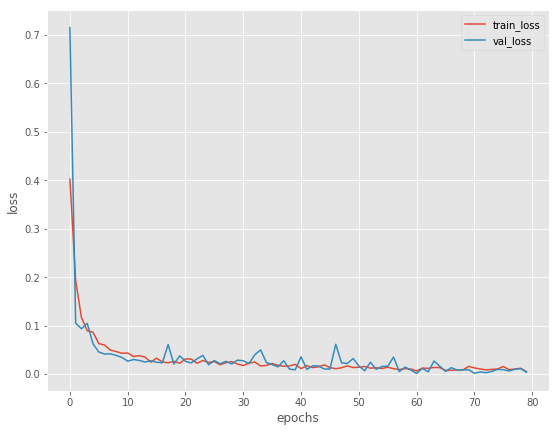

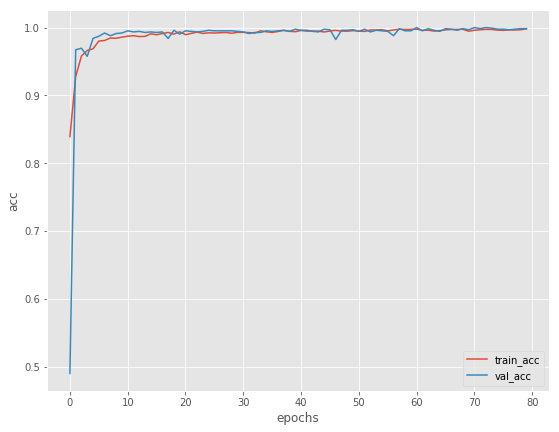

In [10]:
SAVE_DIR = './mobilenetv2_80_'
schedule = default_lr_schedule()
# тренируем сеть на основе MobileNet v2 с количеством классов = 2 batch_size = 128
# в течении 80 эпох постепенно уменьшая LR
model = TrainClassifier(2, batch_size = 128)
model.with_epochs(80).with_optimizer('adam', lr_schedule = schedule).with_graph()
model.do_fit(train_dataset, val_dataset, enable_tqdm=True).display_all()
# сохраняем словарь нейросети на диске
model.save_dict(SAVE_DIR+'1')

In [11]:
#делаем независимую проверку точности на тестовом датасете
model.do_evaluate(test_dataset);

evaluation loss/acc:  0.00023429394059348851 1.0


In [13]:
# функции для использования в чат-боте
import numpy as np
import torch
from torch import nn
from torchvision.models import mobilenet_v2
MODEL = None
RESCALE_SIZE = 224


def get_model(n_outputs = 2):
    simple_cnn = mobilenet_v2(pretrained=False)
    simple_cnn.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.BatchNorm1d(1280),
        nn.Linear(1280, n_outputs, bias=True))
    return simple_cnn


def load_state_dict(neuralnet, name):
    neuralnet.load_state_dict(torch.load(name))
    return neuralnet


def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


def get_image(img_name):
    # для преобразования изображений в тензоры PyTorch и нормализации входа
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    image = Image.open(img_name)
    image.load()
    x = np.array(image.resize((RESCALE_SIZE, RESCALE_SIZE)))
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    return x


In [20]:
# код для использования в чат-боте
if MODEL is None:
    model = mobilenetv2()
    load_state_dict(model, './mobilenetv2_80_1.dict')
    MODEL = model
    

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
img = get_image('./yama.jpg')
prob_pred = predict_one_sample(MODEL, img[None,...])
print(prob_pred)
y_pred = np.argmax(prob_pred)
predicted_label = label_encoder.classes_[y_pred]
print(predicted_label, 'asphalt' if predicted_label == '0' else 'defect')
img = get_image('./none.jpg')
prob_pred = predict_one_sample(MODEL, img[None,...])
y_pred = np.argmax(prob_pred)
predicted_label = label_encoder.classes_[y_pred]
print(predicted_label, 'asphalt' if predicted_label == '0' else 'defect')



[[0.0038044 0.9961957]]
1 defect
0 asphalt
